# Train a new model

In [0]:
# google colab does not come with torch installed. And also, in course we are using torch 0.4. 
# so following snippet of code installs the relevant version

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

  HTTP error 403 while getting http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
  Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl


In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

In [0]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


5.3.0


In [0]:
# Imports here
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import time
import os
import argparse
from torchvision import datasets, models, transforms, utils
from torch.autograd import Variable
import torch.nn.functional as F
import copy
from PIL import Image
import matplotlib.pyplot as plt
import json
from collections import OrderedDict

## Load the data
Uplaod data.zip training dataset . 
more details in readme file that 

In [0]:
!unzip -qq data.zip

In [ ]:
data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

nThreads = 4
batch_size = 8
use_gpu = torch.cuda.is_available()

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


In [0]:
# TODO: Load the datasets with ImageFolder
image_datasets = dict()
image_datasets['train'] = datasets.ImageFolder(train_dir, transform=train_transforms)
image_datasets['valid'] = datasets.ImageFolder(valid_dir, transform=valid_transforms)
image_datasets['test'] = datasets.ImageFolder(test_dir, transform=test_transforms)

In [66]:
# TODO: Using the image datasets and the trainforms, define the dataloaders

dataloaders = dict()
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True)
dataloaders['valid'] = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size)
dataloaders['test']  = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size)

#TODO: Know your data
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

print ("Dasaset Size: "+ str(dataset_sizes) + "\n")
n_class = len(class_names)
print ("Number of classes: "+ str(n_class) + "\n")
print ("Classes: "+ str(class_names) + "\n")

print (len(dataloaders))

Dasaset Size: {'train': 24, 'valid': 24, 'test': 24}

Number of classes: 2

Classes: ['1', '2']

3


### Label mapping



In [67]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    print(cat_to_name)

{'1': 'bottle', '2': 'Car'}


# Building and training the classifier

In [0]:
#Helper Functions

# Function for training the model
'''Credit : Inspired from pytoch doc tutorial (https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)'''

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_accu = 0.0
    
    valid_loss_min = np.Inf # track change in validation loss

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
               
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                  pass # print(phase, preds, labels.data);
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accu = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Accu: {:.4f}'.format(
                phase, epoch_loss, epoch_accu))

            # deep copy the model
            if phase == 'valid':
                if epoch_loss <= valid_loss_min:
                    valid_loss_min = epoch_loss
              
                if epoch_accu >= best_accu:
                    best_accu = epoch_accu
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print("Model Overwritten");

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Min val Loss: {:4f}'.format(valid_loss_min))
    print('Best val Accu: {:4f}'.format(best_accu))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [69]:
# TODO: Build and train your network

# 1. Load a pre-trained network
model = models.densenet161(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [70]:
model.classifier.in_features

2208

In [0]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

num_features = model.classifier.in_features

classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(num_features, 512)),
                              ('relu', nn.ReLU()),
                              ('drpot', nn.Dropout(p=0.5)),
                              ('hidden', nn.Linear(512, 100)),                       
                              ('fc2', nn.Linear(100, 2)),
                              ('output', nn.LogSoftmax(dim=1)),
                              ]))

model.classifier = classifier

In [72]:
# 3. Train the classifier layers using backpropagation using the pre-trained network to get the features
# 4. Track the loss and accuracy on the validation set to determine the best hyperparameters

num_epochs = 25
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=num_epochs)

Using GPU: True
Epoch 0/24
----------
train Loss: 0.7595 Accu: 0.5000
valid Loss: 0.3719 Accu: 1.0000
Model Overwritten
Epoch 1/24
----------
train Loss: 0.7236 Accu: 0.6250
valid Loss: 0.1499 Accu: 1.0000
Model Overwritten
Epoch 2/24
----------
train Loss: 0.3519 Accu: 0.7917
valid Loss: 0.1620 Accu: 1.0000
Model Overwritten
Epoch 3/24
----------
train Loss: 0.2497 Accu: 0.8750
valid Loss: 0.0323 Accu: 1.0000
Model Overwritten
Epoch 4/24
----------
train Loss: 0.0609 Accu: 1.0000
valid Loss: 0.0318 Accu: 1.0000
Model Overwritten
Epoch 5/24
----------
train Loss: 0.0758 Accu: 1.0000
valid Loss: 0.0102 Accu: 1.0000
Model Overwritten
Epoch 6/24
----------
train Loss: 0.0702 Accu: 1.0000
valid Loss: 0.0030 Accu: 1.0000
Model Overwritten
Epoch 7/24
----------
train Loss: 0.0238 Accu: 1.0000
valid Loss: 0.0029 Accu: 1.0000
Model Overwritten
Epoch 8/24
----------
train Loss: 0.0190 Accu: 1.0000
valid Loss: 0.0031 Accu: 1.0000
Model Overwritten
Epoch 9/24
----------
train Loss: 0.0641 Accu: 1

In [73]:
# TODO: Do validation on the test set
def perform_testing():
    loss_fn = nn.NLLLoss()
    model.eval()

    accuracy = 0
    test_loss = 0
    for ii, (images, labels) in enumerate(dataloaders['test']):

        # Set volatile to True so we don't save the history
        with torch.no_grad():
          if use_gpu:
              inputs = Variable(images.cuda())
              labels = Variable(labels.cuda())
          else:
              inputs = Variable(images)
              labels = Variable(labels)

        output = model.forward(inputs)
        test_loss += loss_fn(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output).data
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    print("Batch: {} ".format(ii+1),
          "Test Loss: {:.3f}.. ".format(test_loss/len(dataloaders['test'])),
          "Test Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

perform_testing()

Batch: 3  Test Loss: 0.002..  Test Accuracy: 1.000


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 
model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model.state_dict(),
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'object-detect.pth')

## Loading the checkpoint

In [75]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.densenet161(pretrained=False)
    
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(num_features, 512)),
                              ('relu', nn.ReLU()),
                              ('drpot', nn.Dropout(p=0.5)),
                              ('hidden', nn.Linear(512, 100)),                       
                              ('fc2', nn.Linear(100, 2)),
                              ('output', nn.LogSoftmax(dim=1)), 
                              ]))
    
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']
  
# get index to class mapping
loaded_model, class_to_idx = load_checkpoint('object-detect.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [76]:
# Testing checkpoint

loaded_model.eval()
images, labels = next(iter(dataloaders['test']))
output = loaded_model.forward(Variable(images[:2]))
ps = torch.exp(output).data
print(ps.max(1)[1])

tensor([0, 0])


In [0]:
!wget -cq https://github.com/mdmamunhasan/pytorch_challenge/raw/master/flower_test_data.zip
!unzip -qq flower_test_data.zip

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [80]:
print (predict('data/test/2/image_00018.jpg', loaded_model))

(array([0.998977  , 0.00102295], dtype=float32), ['2', '1'])


## Sanity Checking


In [0]:
# TODO: Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

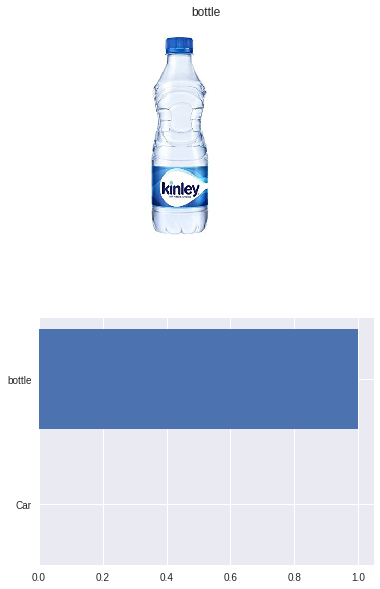

In [88]:
img = 'data/test/1/image_00001.jpg'
#img = 'test.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'densenet161.pth'})
uploaded.SetContentFile('densenet161.pth')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))